# Entraînement d'un réseau U-Net pour la segmentation de tumeurs dans des images 2D issues du dataset BraTS 2019

Le code présenté ci-dessous permet la création, l'entraînement et l'évaluation d'un modèle de réseau de neurones reprenant l'architecture U-Net pour la segmentation de tissus tumoraux.

## Introduction

Cette section détaille les entrées-sorties de ce programme, ainsi que la configuration recommandée et les librairies utilisées pour le faire fonctionner.

### Données d'entrée

Ce code fonctionne en conjonction avec le code de pré-traîtement des données de la base BraTS 2019 fourni. Il permet de travailler avec des données multimodales en empilant les données issues des acquisitions suivantes : 
-  Pondération T1 (T1)
-  Pondération T1 avec augmentation du contraste (T1CE)
-  Pondération T2 (T2)
-  Pondération T2 avec atténuation des fluides par inversion-récupération (FLAIR)

Se reporter à la [page de description du dataset BraTS 2019](https://www.med.upenn.edu/cbica/brats2019/data.html) pour plus d'informations

### Données de sortie

Le modèle permet de générer une segmentation en 5 classes qui sont : 
-  Extérieur du cerveau - (classe 0)
-  Tissu sain - (classe 1)
-  *Necrotic and non-enhancing tumor core* - (classe 2)
-  *Peritumoral edema* - (classe 3)
-  *GD-enhancing tumor* - (classe 4)

### Configuration

Ce code a été conçu et testé avec la configuration suivante : 
-  Python 3.10
-  CUDA Toolkit 11.2
-  CuDNN 8.1
-  Tensorflow 2.10
-  Pandas 1.5
-  Matplotlib 3.7
-  Scikit-learn 1.2

Il nécessite l'import des librairies et fonctions suivantes : 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import csv
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical

## Création des datasets

Cette section détaille la façon dont sont organisés et construits les datasets d'entraînement et de validation.

### Organisation des datasets d'entraînement et de validation

Lors de la création des datasets d'entraînement et de validation, ceux-ci sont fractionnés en subdivisions de 500 images maximum. En effet, les données pré-traîtées étant de grande dimmensionnalité (volume 3D à 5 canaux) et compressées au format .npz, il faut compter plusieurs secondes de chargement pour accéder à ces données. Le regroupement en subdivisions permet d'aggréger uniquement les données nécessaires en volumes de taille intermédiaire, limitant le temps passé à charger/décompresser des données, mais suffisament grands pour permettre un mélange des images lors du regroupement par batch. Les informations sur chaque image stockée dans chaque subdivision sont stockées dans un fichier d'index au format .csv. Un second fichier d'index recense les paramètres utilisés pour la création de ces datasets.

### Paramètres de création des datasets

Dans la cellule ci-dessous, il est possible de définir tous les paramètres de création des datasets : 
-  **reuse_index** : Variable booléenne indiquant si les fichiers d'index et de paramètres existants doivent être réutilisés. Si aucun fichier d'index correspondant aux paramètres d'entraînement n'est trouvé, ce fichier est créé, ce qui cause la création de nouvelles subdivisions. En cas de réutilisation, les paramètres *channels*, *image_axis*, *train_size* et *validation_ratio* sont écrasés et remplacés par ceux présents dans les fichiers d'index.
-  **rebuild_dataset** : Variable booléenne indiquant s'il faut reconstruire les subdivisions à partir d'un fichier d'index. Si aucun fichier d'index n'existe, les subdivisions seront recréées après ledit fichier d'index.
-  **channels** : Liste des canaux IRM à inclure lors de l'entraînement.
-  **image_axis** : Axe de coupe de l'image. 0 : X (plan YZ), 1 : Y (plan XZ), 2 : Z (plan XY)
-  **train_size** : Taille du dataset d'entraînement, en nombre d'images.
-  **validation_ratio** : Taille du dataset de validation, exprimé en proportion de la taille du dataset d'entraînement. *Par exemple, avec un ratio de 0.1 et un dataset d'entraînement de 1000 images, le dataset de validation comportera 100 images*

Attention, s'il est indiqué que les ensembles d'entraînement et de validation doivent inclure plus d'images que n'en contient la base, ceux-ci seront redimensionnés en conservant leur ratio pour inclure toutes les images de la base.

In [2]:
# Paramètres de création des datasets

reuse_index = True 
rebuild_dataset = False
channels = ["flair","t1", "t1ce", "t2"]
image_axis = 2
train_size = 1000
validation_ratio = 0.1

### Construction des fichiers d'index

La fonction ci-dessous se charge de créer les fichiers d'index permettant la construction des datasets. 

Le premier fichier d'index (appelé par la suite le *fichier de paramètres*) contient les paramètres de création des datasets suivants : 
-  **image_axis** : Axe de coupe des images
-  **channels** : Canaux utilisés
-  **img_shape** : Dimensions des images sélectionnées
-  **train_size** : Taille du dataset d'entraînement
-  **validation_ratio** : Taille du dataset de validation

Le second fichier d'index (appelé par la suite le *fichier d'annuaire*) permet de garder la trace des images sélectionnées dans chaque subdivision des datasets. Il s'agit d'in fichier .csv avec les champs suivants, détaillés pour chaque image incluse dans les datasets : 
-  **subset_name** : Nom du fichier de subdivision dans lequel l'image est intégrée
-  **train_or_test** : String pouvant valoir *'train'* ou *'test'* indiquant si l'image fait partie du dataset d'entraînement ou de validation
-  **subset_position** : Position de l'image au sein de la subdivision (allant de 0 à 499)
-  **file_name** : Chemin et nom du fichier .npz issu de la base pré-traîtée dont l'image est tirée
-  **slice** : Position de l'image dans le volume 3D dont elle est issue, suivant l'axe indiqué par *image_axis*.

Ces fichiers d'index sont enregistrés dans un dossier nommé **./datasets/2d_{N}k/** qui est créé s'il n'existe pas, où **{N}** est le nombre de milliers d'images (arrondi à l'entier inférieur) incluses dans le dataset d'entraînement. Le fichier d'annuaire est nommé **index.csv**  et le fichier de paramètres est nommé **parameters.csv**. 

La variable d'entrée **path_to_data** est la liste des chemins vers les volumes 3D pré-traîtés d'où seront tirées les images à inclure dans les datasets, et la variable **dataset_path** est le chemin dans lequel le dataset est stocké.

In [3]:
def build_index(path_to_data, dataset_path, train_size, validation_ratio, image_axis, channels, img_shape):
    
    os.makedirs(dataset_path, exist_ok=True)
    
    # Construction du fichier de paramètres
    param_file = open(os.path.join(dataset_path, 'parameters.csv'), mode='w')
    param_names = ['image_axis', 'channels', 'img_shape', 'train_size', 'validation_ratio']
    writer_param = csv.DictWriter(param_file, fieldnames=param_names)
    writer_param.writeheader()
    dico_param = {'image_axis' : image_axis, 
                  'channels' : channels, 
                  'img_shape' : img_shape, 
                  'train_size' : train_size, 
                  'validation_ratio' : validation_ratio, 
                 }
    writer_param.writerow(dico_param)
    param_file.close()
    
    # Tirage aléatoire des images qui seront incluses dans les datasets
    rp = np.random.permutation(img_shape[3]*len(path_to_data))
    validation_size = int(train_size* validation_ratio)
    rp = rp[:(train_size + validation_size)]
    datasets = []
    for k in range(len(rp)):
        datasets.append((path_to_data[rp[k]//img_shape[3]], rp[k]%img_shape[3]))

    # Construction du fichier d'annuaire
    index_file = open(os.path.join(dataset_path, 'index.csv'), mode='w')
    field_names = ['subset_name', 'train_or_test', 'subset_position', 'file_name', 'slice']
    writer = csv.DictWriter(index_file, fieldnames=field_names)
    writer.writeheader()
    
    dico = {'train_or_test' : 'train'}
    for i in range(train_size):
        if i % 500 == 0:
            dico['subset_name'] = os.path.join(dataset_path, 'train_{0:d}'.format(i//500))
 
        dico['subset_position'] = i % 500 
        dico['file_name'] = datasets[i][0]
        dico['slice'] = datasets[i][1]

        writer.writerow(dico)
        
    dico['train_or_test'] = 'test'
    for i in range(validation_size):
        if i % 500 == 0:
            dico['subset_name'] = os.path.join(dataset_path, 'test_{0:d}'.format(i//500))
 
        dico['subset_position'] = i % 500
        dico['file_name'] = datasets[i + train_size][0]
        dico['slice'] = datasets[i + train_size][1]
        
        writer.writerow(dico)
        
    index_file.close()   
    
    return

### Lecture du fichier de paramètres

La fonction suivante se charge de récupérer les paramètres de création des datasets dans le fichier de paramètre. 

La variable d'entrée **dataset_path** contient le chemin vers le dossier dans lequel est stocké le dataset.

Cette fonction renvoie les valeurs des variables **train_size** , **validation_ratio** , **image_axis** , **channels** et **img_shape**.

In [4]:
def read_params_from_index(dataset_path):
    # Récupération des paramètres d'entraînement de l'index
    params = pd.read_csv(os.path.join(dataset_path, 'parameters.csv')).dropna()
    img_shape = params['img_shape'][0]
    channels = params['channels'][0]
    image_axis = params['image_axis'][0]
    train_size = params['train_size'][0]
    validation_ratio = params['validation_ratio'][0]
    
    img_shape = img_shape[1:-1]
    img_shape = tuple(map(int, img_shape.split(', ')))
    
    channels = channels[1:-1]
    channels = list(map(str, channels.split(', ')))
    for k in range(len(channels)):
        channels[k] = channels[k][1:-1]
    
    return train_size, validation_ratio, image_axis, channels, img_shape
    

### Construction des subdivisions à partir des fichiers d'index

La fonction ci-dessous se charge, à partir des fichiers d'index créés ou fournis, de créer, remplir et sauvegarder les subdivisions des datasets. Ces subdivisions sont stockées au format .npz dans le dossier **./datasets/2d_{N}k/**, où **{N}** est le nombre de milliers d'images (arrondi à l'entier inférieur) incluses dans le dataset d'entraînement.

Chaque fichier du dataset d'entraînement est nommé **train_{i}.npz** où **{i}** est le numéro de la subdivision. Les fichiers du dataset de validation sont quant-à-eux nommés **test_{i}.npz**. 

Cette fonction prend en entrée les variables **dataset_path** , **image_axis** , **channels** et **img_shape**.

In [5]:
def build_sub_datasets_from_index(dataset_path, image_axis, channels, img_shape):

    # Order des canaux dans la base pré-traîtée
    channel_order = {"flair" : 0, "t1" : 1, "t1ce" : 2, "t2" : 3}
    
    #Construction des datasets à partir du fichier d'index
    index = pd.read_csv(os.path.join(dataset_path, 'index.csv')).dropna()    
    sub_names = index.subset_name.unique()
    
    for subset_name in sub_names:
        # Pour chaque subdivision du dataset on sélectionne les images sensées être incluses
        subset_index = index.loc[index['subset_name'] == subset_name]
        data = np.zeros((len(subset_index.index), img_shape[0], img_shape[1], img_shape[2]))
        seg = np.zeros((len(subset_index.index), img_shape[0], img_shape[1]))
        subset_files = subset_index.file_name.unique()
        
        for file in subset_files :
            #Pour chaque cas apparaîssant dans cette subdivision, on charge l'image et la segmentation, et on sélectionne le plan de coupe
            loaded = np.load(file)
            file_data = loaded['data'].swapaxes(0,image_axis)
            file_seg = loaded['seg'].swapaxes(0,image_axis)
            del loaded
            
            slices = subset_index.loc[subset_index['file_name'] == file]
            for i in range(len(slices.index)): 
                # Pour chaque coupe
                for j in range(len(channels)):
                    # Copie des images pour chaque canal selectionné
                    data[slices.subset_position.iloc[i],:,:,j] = file_data[slices.slice.iloc[i],:,:,channel_order[channels[j]]]   
                # Copie de la carte de segmentation
                seg[slices.subset_position.iloc[i],:,:] = file_seg[slices.slice.iloc[i],:,:]   
        
        # Sauvegarde de la subdivision
        np.savez_compressed(subset_name, data=data.astype("float32"), seg=seg.astype("byte"))
    
    return

### Construction des datasets

Cette fonction se charge de construire ou récupérer les datasets pour l'entraînement. Elle applique dans cet ordre les tâches suivantes : 

-  Récupération de la liste des fichiers pré-traîtés présents dans le dossier **./preprocessed_data/** que l'on joint avec le chemin dudit dossier, et on stocke le tout dans la liste **path_to_data**. 
-  Chargement du premier fichier de cette liste pour mesurer la taille des images que l'on aura à traîter, stockée dans le tuple **img_shape**. Les deux premiers champs de ce tuple contiennent les dimensions par canal de chaque image, le troisième champ contient le nombre de canaux utilisés pour l'apprentissage, et le dernier champ indique le nombre de coupes qu'il est possible de faire dans chaque fichier. 
-  Vérification de la taille du dataset. Si la taille demandée est supérieure au nombre d'images présentes dans la base, on recalcule la valeur de la variable **train_size** pour que toutes les images soient incluses dans le dataset en conservant la même valeur de **validation_ratio**.
-  Si nécessaire, construction des fichiers d'index en appelant la fonction dédiée.
-  Récupération des paramètres dans le fichier de paramètres, à l'aide de la fonction adéquate. Si ces paramètres sont différents de ceux entrés précédemments car extraits d'un fichier d'index pré-existant, ils les écrasent.
-  Si nécessaire, Création des subdivisions des datasets en appelant la fonction dédiée.
-  Récupération dans les fichiers d'index les noms et chemins des fichiers de subdivision, que l'on stocke sous forme de liste dans **train_dataset** pour les données d'entraînement et dans **test_dataset** pour les données de validation.

Cette fonction prend en entrée les paramètres de création des datasets, et renvoie ces mêmes paramètres, mis à jour s'ils sont issus des fichiers d'index, ainsi que les listes **train_dataset** et **test_dataset** et le tuple de mesure des dimensions des images.

In [6]:
def build_datasets(train_size, validation_ratio, image_axis, channels, reuse=False, rebuild=True):
    
    # Récupération des chemins des fichiers pré-traîtés
    list_of_files = os.listdir('./preprocessed_data/')
    path_to_data = []
    for file in list_of_files:
        path_to_data.append(os.path.join('preprocessed_data', file))

    # Taille des images d'entrée   
    loaded = np.load(path_to_data[0])
    img = loaded['data'].swapaxes(0,image_axis)
    img_shape = (img.shape[1], img.shape[2], len(channels), img.shape[0])
    del img, loaded
    
    # Vérification de la taille du dataset
    if train_size + int(np.floor(train_size * validation_ratio)) > (335*img_shape[3]) :
        train_size = 335*img_shape[3] - int(np.floor((335*img_shape[3]*validation_ratio)/(1+validation_ratio)))
    
    # Construction des fichiers d'index
    dataset_path = os.path.join('datasets', '2d_{0:d}k'.format(train_size//1000))
    if not(reuse & os.path.exists(os.path.join(dataset_path, 'index.csv')) & os.path.exists(os.path.join(dataset_path, 'index.csv'))) :
        build_index(path_to_data, dataset_path, train_size, validation_ratio, image_axis, channels, img_shape)
        rebuild = True
        
    # Lecture des paramètres inclus dans le fichier de paramètres
    train_size, validation_ratio, image_axis, channels, img_shape = read_params_from_index(dataset_path)
    
    # Construction des subdivisions
    if rebuild :
        build_sub_datasets_from_index(dataset_path, image_axis, channels, img_shape)
    
    # Création des listes des fichiers de subdivisions des ensembles d'entraînement et de validation.
    index = pd.read_csv(os.path.join(dataset_path, 'index.csv')).dropna()
    sub_names = index.subset_name.unique()
    train_dataset = []
    test_dataset = []
    for sub_name in sub_names :
        if index[index.subset_name==sub_name].train_or_test.iloc[0] == 'train':
            train_dataset.append(sub_name + '.npz')
        else:
            test_dataset.append(sub_name + '.npz')
            
    return train_dataset, test_dataset, train_size, validation_ratio, image_axis, channels, img_shape

Il suffit ensuite d'une ligne pour gérer entièrement la création des datasets :

In [7]:
train_dataset, test_dataset, train_size, validation_ratio, image_axis, channels, img_shape = build_datasets(train_size, validation_ratio, image_axis, channels, reuse=reuse_index, rebuild=rebuild_dataset)

## Création du modèle

Le réseau de neurones utilisé pour réaliser cette segmentation est basé sur l'architecture [U-Net](https://fr.wikipedia.org/wiki/U-Net). Cette architecture est particulièrement adaptée à la segmentation d'images. Ce modèle est composé de blocs de trois natures différentes :

### Bloc d'encodage

Ce bloc a pour tâche de compresser les données, en réduisant leur dimension spatiale mais en augmentant leur dimension sémantique. Il est composé de :
-  Une couche de convolution 2D comprenant un nombre de filtres grandissant avec la profondeur dans le réseau
-  Une couche de normalisation qui peut être shuntée
-  Une couche d'activation *Leaky ReLU*

In [8]:
def encoding_block(layer_in, n_filters, stride, apply_batchnorm=True):
    init = tf.random_normal_initializer(0., 0.02, 0)
    g = Conv2D(n_filters, (stride+2,stride+2), strides=(stride,stride), padding='same', kernel_initializer=init)(layer_in)
    if apply_batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

### Goulot d'étranglement

Ce bloc traîte les données issues de la cascade d'encodage, sans en modifier la dimmensionnalité. Il est composé de trois couches de convolution 2D suivies chacune d'une couche d'activation ReLU

In [9]:
def bottleneck(layer_in, n_filters):
    init = tf.random_normal_initializer(0., 0.02, 0)
    # bottleneck, no batch norm and relu
    b1 = Conv2D(n_filters, (3,3), strides=(1,1), padding='same', kernel_initializer=init)(layer_in)
    b1 = Activation('relu')(b1)
    b2 = Conv2D(n_filters, (3,3), strides=(1,1), padding='same', kernel_initializer=init)(b1)
    b2 = Activation('relu')(b2)
    b3 = Conv2D(n_filters, (3,3), strides=(1,1), padding='same', kernel_initializer=init)(b2)
    b3 = Activation('relu')(b3)
    return b3

### Bloc de décodage

Ce bloc a pour tâche de décompresser les données issues de la couche précédente et de les mettre en relation avec les données sorties du bloc d'encodage de même dimmensionnalité, avant le goulot d'étranglement. Il est composé de :
-  Une couche de déconvolution 2D dont le nombre de filtres diminue avec la profondeur du réseau
-  Une couche de normalisation
-  Une couche de *dropout*
-  Une couche de concaténation des données d'agrégation avec les données issues du bloc d'encodage
-  Une couche d'activation *ReLU*

In [10]:
def decoding_block(layer_in, skip_in, n_filters, stride, dropout=True):
    init = tf.random_normal_initializer(0., 0.02, 0)
    g = Conv2DTranspose(n_filters, (stride+2,stride+2), strides=(stride,stride), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.2)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

### Réseau complet

Le réseau s'architecture de la façon suivante : 
-  Une étape d'encodage constituée de 5 blocs d'encodage successifs, divisant chacun la taille des images par 2 ou 3 et augmentant la profondeur du tenseur de données à chaque couche, permettant d'atteindre une profondeur de 1024 canaux
-  Un goulot d'étranglement
-  Une étape de décodage constituée de 5 blocs de décodage réduisant la profondeur du tenseur de données jusqu'à 64 canaux
-  Une dernière couche de déconvolution suivie du'une couche d'activation *softmax* permettant d'effectuer la classification

In [23]:
def build_unet(image_shape):
    
    init = tf.random_normal_initializer(0., 0.02, 0)
    inputs = Input(shape=image_shape[:3])
    
    # Encodage
    e1 = encoding_block(inputs, 64, 2, apply_batchnorm=False) # Taille de sortie : (120x120x64) ou (120x72x64)
    e2 = encoding_block(e1, 128, 2)                            # Taille de sortie : (60x60x128) ou (60x36x128)
    e3 = encoding_block(e2, 256, 2)                           # Taille de sortie : (30x30x256) ou (30x18x256)
    e4 = encoding_block(e3, 512, 2)                           # Taille de sortie : (15x15x512) ou (15x9x512)
    e5 = encoding_block(e4, 512, 3)                           # Taille de sortie : (5x5x1024) ou (5x3x1024)
    
    # Goulot d'étranglement
    b = bottleneck(e5, 512)
    
    # Décodage
    d1 = decoding_block(b, e5, 512, 1)
    d2 = decoding_block(d1, e4, 512, 3)
    d3 = decoding_block(d2, e3, 512, 2, dropout=False)
    d4 = decoding_block(d3, e2, 256, 2, dropout=False)
    d5 = decoding_block(d4, e1, 128, 2, dropout=False)
    
    # Sortie
    g = Conv2DTranspose(5, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d5)
    output = Activation('softmax')(g)
    
    # Construction du modèle
    model = Model(inputs, output)
    return model

### Construction du modèle

Le morceau de code suivant permet le chargement ou la construction du modèle. 

Si la variable booléenne **load_model** est à ***True***, le programme cherche s'il existe un modèle pré-existant et si oui il le charge. Ce modèle doit être situé dans le dossier **./models/**, et nommé **Model_2d_{N}k.hdf5**, où **{N}** est le nombre de milliers d'images (arrondi à l'entier inférieur) incluses dans le dataset d'entraînement.

Si ce modèle n'existe pas, ou si **load_model** est à ***False***, le programme le crée et le compile en utilisant l'optimiseur *Adam* avec un taux d'apprentissage à 2e-4. Si un modèle avec ce nom existait précédemment, il est écrasé.

La fonction de coût (*Loss*) est une entropie binaire croisée, idéale pour les tâches de classification.

Enfin, on affiche le résumé de l'archtecture du modèle.

In [24]:
load_model = False
if load_model & os.path.exists(os.path.join('models', 'Model_2d_{0:d}k.hdf5'.format(train_size//1000))):
    unet_model = tf.keras.models.load_model(os.path.join('models', 'Model_2d_{0:d}k.hdf5'.format(train_size//1000)))
else :
    os.makedirs('models', exist_ok=True)
    unet_model = build_unet(img_shape)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    unet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=opt, loss_weights=[0.5])
    tf.keras.models.save_model(unet_model, os.path.join('models', 'Model_2d_{0:d}k.hdf5'.format(train_size//1000)))

unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 240, 240, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 120, 120, 64  4160        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_10 (LeakyReLU)     (None, 120, 120, 64  0           ['conv2d_16[0][0]']              
                                )                                                           

## Mesure des performances du modèle

Cette section détaille la façon dont le performances du réseau sont mesurées et visualisées

### Visualisation des résultats

Cette fonction se charge d'afficher les résultats du réseau, en affichant côte-à-côte les données d'entrée, la carte de segmentation issue du dataset et la carte de segmentation générée par le réseau de neurones. 

Chaque ligne de la sortie correspond à une image d'entrée. Les données d'entrée sont affichées dans l'ordre de la liste **channels**, suivie de la carte de segmentation originale, et enfin la carte de prédiction. Le nombre de ligne à afficher est donné par la taille du batch.

Cette fonction prend en entrée les cartes de données **data**, la carte de segmentation prédite **pred**, la carte de segmentation originale **seg** et le nombre d'images dans le batch **n_sample**.

In [13]:
def visualize(data, pred, seg, n_sample):

    n_img_per_case = 2 + data.shape[3]
    plt.figure(figsize=(5*n_img_per_case, 5*n_sample))
    
    for i in range(n_sample):
        
        for j in range(data.shape[3]):
            plt.subplot(n_sample, n_img_per_case, n_img_per_case * i + j + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(data[i,:,:,j], vmin=-1, vmax=1)
        
        plt.subplot(n_sample, n_img_per_case, n_img_per_case * (i + 1) - 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(seg[i,:,:], vmin=0, vmax=4)
            
        plt.subplot(n_sample, n_img_per_case, n_img_per_case * (i + 1))
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(pred[i,:,:], vmin=0, vmax=4)

    plt.show()
    return    

### Mesure des performances

Cette fonction calcule et affiche les performances du modèle sur un dataset. Pour cela, on calcule la précision, la sensibilité et le score F1 pour chaque image du dataset et pour chaque classe.

Ces grandeurs sont définies de la façons suivante (pour l'image $i$ et la classe $k$): 
-  Sensibilité : $S_{ik} = \frac{TP}{TP + FP}$
-  Précision : $P_{ik} = \frac{TP}{TP + FP}$
-  Score F1 : $F1_{ik} = \frac{2.S.P}{S+P}$

avec 
-  $TP$ le nombre de vrais positifs (nombre de pixels de l'image $i$ correctement classifiés dans la classe $k$)
-  $FP$ le nombre de faux positifs (nombre de pixels de l'image $i$ classifiés dans la classe $k$ mais appartenant à une autre classe)
-  $FN$ le nombre de faux négatifs (nombre de pixels de l'image $i$ appartenant à la classe $k$ mais classifiés dans une autre classe)

On agrège ensuite les résultats en effectuant une moyenne pondérée par classe sur les images. En notant $N_{ik}$ le nombre de pixels de l'image $i$ appartenant à la classe $k$ et $X_k$ le score pour la classe $k$ pour lequel on agrège les résultats des $X_{ik}$, on a :
\begin{equation} 
\mathbb{E}[X_k] = \dfrac{\sum_i N_{ik}.X_{ik}}{\sum_i N_{ik}}
\end{equation}
Et :
\begin{equation} 
\sigma[X_k] = \sqrt{\dfrac{\sum_i N_{ik}^2.X_{ik}^2}{\sum_i N_{ik}^2} - \mathbb{E}[X_k]^2}
\end{equation}

On affiche les résultats sous la forme $\mathbb{E}[X_k] \pm \sigma[X_k]$

On calcule ensuite les scores globaux en agrégeant sur les classes. En notant $X$ le score global d'une image, on a :
\begin{equation} 
\mathbb{E}[X] = \frac{\sum_k \sum_i N_{ik}.X_{ik}}{\sum_k \sum_i N_{ik}}
\end{equation}
Et : 
\begin{equation} 
\sigma[X] = \sqrt{\frac{\sum_k \sum_i N_{ik}^2.X_{ik}^2}{\sum_k \sum_i N_{ik}^2} - \mathbb{E}[X]^2}
\end{equation}

En plus de cela, on calcule également les précision, sensibilité et score F1 binaires, mesurent si chaque pixel a correctement été catégorisé comme tumoral, sans se soucier de quel type de tissu tumoral il s'agit.

Pour finir, si la variable booléenne d'entrée **show** est à ***True***, on appelle la fonction de visualisation pour afficher le dernier batch prédit par le réseau.

Cette fonction prend en entrée le modèle **unet_model**, la liste **dataset** des noms des fichiers de subdivision appartenant au dataset à mesurer, la taille des batchs **batch_size** à faire passer dans le réseau (optionnel, 10 par défaut), et la variable **show**.

Elle renvoie les moyennes et écarts-types des scores par classe, globaux et binaires.

In [26]:
def measure_performance(unet_model, dataset, batch_size = 10, show=False):
    
    scores_weighted_sum = np.zeros((4,5), dtype='float64')
    scores_weighted_squares = np.zeros((4,5), dtype='float64')
    class_scores = np.zeros((4,2,5), dtype='float64')
    global_scores = np.zeros((4,2), dtype='float64')
    binary_scores = np.zeros((4,2), dtype='float64')
    
    for i in range(len(dataset)):
        loaded = np.load(dataset[i])
        data = loaded['data']
        seg = loaded['seg']       
        del loaded
        n_batch = int(np.floor(data.shape[0]/batch_size))
        
        for j in range(n_batch):
            batch_data = data[j*batch_size:(j+1)*batch_size,:,:,:]
            batch_seg = seg[j*batch_size:(j+1)*batch_size,:,:]
            batch_pred = np.argmax(unet_model.predict(batch_data, verbose=0), axis=3)
            for k in range(batch_size):
                precision, recall, F1, support = precision_recall_fscore_support(batch_seg[k,:,:].flatten(), batch_pred[k,:,:].flatten(), 
                                                                                 labels=np.asarray([0, 1, 2, 3, 4]), zero_division=0)

                results = (np.concatenate((precision.reshape((1,5)), recall.reshape((1,5)), F1.reshape((1,5)), np.ones((1,5))), axis=0) * np.dot(np.ones((4,1)), support.reshape((1,5)))).reshape((4,1,5))
                class_scores += np.concatenate((results, results**2), axis=1)
                
                precision, recall, F1, support = precision_recall_fscore_support((batch_seg[k,:,:].flatten() >= 2).astype(int), (batch_pred[k,:,:].flatten() >= 2).astype(int), labels=[1], zero_division=0)
                results = np.asarray([precision, recall, F1, [1]]) * support
                binary_scores += np.concatenate((results, results ** 2), axis=1)
                
    global_scores = class_scores.sum(axis=2)
    
    for k in range(5):
        class_scores[:3,:,k] /= np.dot(np.ones((3,1)), class_scores[3,:,k].reshape((1,2)))
        class_scores[:3,1,k] = np.sqrt(class_scores[:3,1,k] - class_scores[:3,0,k]**2)
        print("Performances pour la classe {0:d} ({1:d} pixels) : Précision {2:.3f}% \u00B1 {3:.3f}% - Sensibilité {4:.3f}% \u00B1 {5:.3f}% - F1 {6:.3f}% \u00B1 {7:.3f}%"
              .format(k, int(class_scores[3,0,k]), class_scores[0,0,k]*100, class_scores[0,1,k]*100, class_scores[1,0,k]*100, class_scores[1,1,k]*100, class_scores[2,0,k]*100, class_scores[2,1,k]*100))    
    
    global_scores[:3,:] /= np.dot(np.ones((3,1)), global_scores[3,:].reshape((1,2)))
    global_scores[:3,1] = np.sqrt(global_scores[:3,1] - global_scores[:3,0]**2)
    print("Performances globales ({0:d} pixels) : Précision {1:.3f}% \u00B1 {2:.3f}% - Sensibilité {3:.3f}% \u00B1 {4:.3f}% - F1 {5:.3f}% \u00B1 {6:.3f}%"
          .format(int(global_scores[3,0]), global_scores[0,0]*100, global_scores[0,1]*100, global_scores[1,0]*100, global_scores[1,1]*100, global_scores[2,0]*100, global_scores[2,1]*100))
    
    binary_scores[:3,:] /= np.dot(np.ones((3,1)), binary_scores[3,:].reshape((1,2)))
    binary_scores[:3,1] = np.sqrt(binary_scores[:3,1] - binary_scores[:3,0]**2)
    
    print("Performances binaires ({0:d} pixels) : Précision {1:.3f}% \u00B1 {2:.3f}% - Sensibilité {3:.3f}% \u00B1 {4:.3f}% - F1 {5:.3f}% \u00B1 {6:.3f}%"
          .format(int(binary_scores[3,0]), binary_scores[0,0]*100, binary_scores[0,1]*100, binary_scores[1,0]*100, binary_scores[1,1]*100, binary_scores[2,0]*100, binary_scores[2,1]*100))
    
    if show :
        visualize(batch_data, batch_pred, batch_seg, batch_size)
    
    return class_scores, global_scores, binary_scores

## Entraînement du modèle

Ici on détaille comment se déroule l'entraînement du modèle.

### Fonction d'entraînement

Cette fonction gère l'organisation de l'entraînement.

A chaque époque, on charge successivement toutes les subdivisions du dataset d'entraînement, que l'on mélange puis divise en batchs. Ce mélange permet de s'assurer de ne pas passer systématiquement les mêmes données dans le même ordre, ce qui dégraderait la qualité de l'entraînement. Le réseau est ensuite entraîné batch par batch.

Après chaque époque, le modèle est sauvegardé, et on affiche la valeur moyenne de la fonction de coût sur l'ensemble des batchs, ainsi que des informations concernant l'avancement, le temps écoulé depuis le début de l'entraînement, la durée totale d'entraînement estimée et le temps restant.

Enfin, toutes les 10 époques, on mesure les performances du réseau sur le dataset de validation, et on en profite pour visualiser un batch de ce dataset.

Cette fonction prend en entrée le modèle **unet_model**, les listes **train_dataset** et **test_dataset** des noms des fichiers de subdivision respectivement du dataset d'entraînement et du dataset de validation, la taille totale du dataset d'entraînement **train_size**, le nombre d'époques d'entraînement **n_epochs** (optionnel, 100 par défaut) et la taille des batchs **batch_size** (optionnel, 10 par défaut).

In [18]:
def train(unet_model, train_dataset, test_dataset, train_size, n_epochs=100, batch_size=10):

    start_time = time.time()
    for epoch in range(n_epochs):
        batch_losses = np.zeros(int(np.floor(train_size/batch_size)))
        k_batch = 0
        for k in range(len(train_dataset)):
            loaded = np.load(train_dataset[k])
            data = loaded['data']
            seg = loaded['seg']
            del loaded
        
            # Mélange du dataset
            rp = np.random.permutation(data.shape[0])
            n_batch = int(np.floor(data.shape[0]/batch_size))            
            
            for batch in range(n_batch):
                batch_data = data[rp[batch*batch_size : (batch+1)*batch_size],:,:,:]
                batch_seg = to_categorical(seg[rp[batch*batch_size : (batch+1)*batch_size],:,:], num_classes=5)
                batch_losses[k_batch] = unet_model.train_on_batch(batch_data, batch_seg)
                k_batch += 1
        
        tf.keras.models.save_model(unet_model, os.path.join('models', 'Model_2d_{0:d}k.hdf5'.format(train_size//1000)))
        
        if (epoch+1)%10 == 0 :
            print("Evaluation des performances")
            class_scores, global_scores, binary_scores = measure_performance(unet_model, test_dataset, batch_size = 10, show=True)
            
        stop_time = time.time()
        avancement = (epoch+1)/(n_epochs)
        duree = stop_time - start_time
        duree_totale = duree / avancement
        ETA = duree_totale - duree
        print("Avancement : {0:.2f}%, Temps écoulé : {1:d}h {2:02d}m {3:02d}s, Temps restant estimé: {4:d}h {5:02d}m {6:02d}s, Loss = {7:.6f}"
              .format(round(100*avancement,2), int(duree)//3600, (int(duree)//60)%60, int(duree)%60, int(ETA)//3600, (int(ETA)//60)%60, int(ETA)%60, np.mean(batch_losses)))

### Exécution de l'entraînement

Ici, on exécute la fonction d'entraînement. On peut auparavant choisir le nombre d'époques d'entraînement **n_epochs** et la taille des batchs **batch_size**

Avancement : 1.00%, Temps écoulé : 0h 00m 30s, Temps restant estimé: 0h 49m 56s, Loss = 0.083360
Avancement : 2.00%, Temps écoulé : 0h 00m 54s, Temps restant estimé: 0h 44m 08s, Loss = 0.012093
Avancement : 3.00%, Temps écoulé : 0h 01m 17s, Temps restant estimé: 0h 41m 54s, Loss = 0.008849
Avancement : 4.00%, Temps écoulé : 0h 01m 41s, Temps restant estimé: 0h 40m 35s, Loss = 0.007870
Avancement : 5.00%, Temps écoulé : 0h 02m 05s, Temps restant estimé: 0h 39m 40s, Loss = 0.007063
Avancement : 6.00%, Temps écoulé : 0h 02m 29s, Temps restant estimé: 0h 39m 04s, Loss = 0.006519
Avancement : 7.00%, Temps écoulé : 0h 02m 53s, Temps restant estimé: 0h 38m 24s, Loss = 0.006251
Avancement : 8.00%, Temps écoulé : 0h 03m 17s, Temps restant estimé: 0h 37m 48s, Loss = 0.005884
Avancement : 9.00%, Temps écoulé : 0h 03m 41s, Temps restant estimé: 0h 37m 14s, Loss = 0.005561
Evaluation des performances
Performances pour la classe 0 (4564393 pixels) : Précision 99.751% ± 1.620% - Sensibilité 99.788% ±

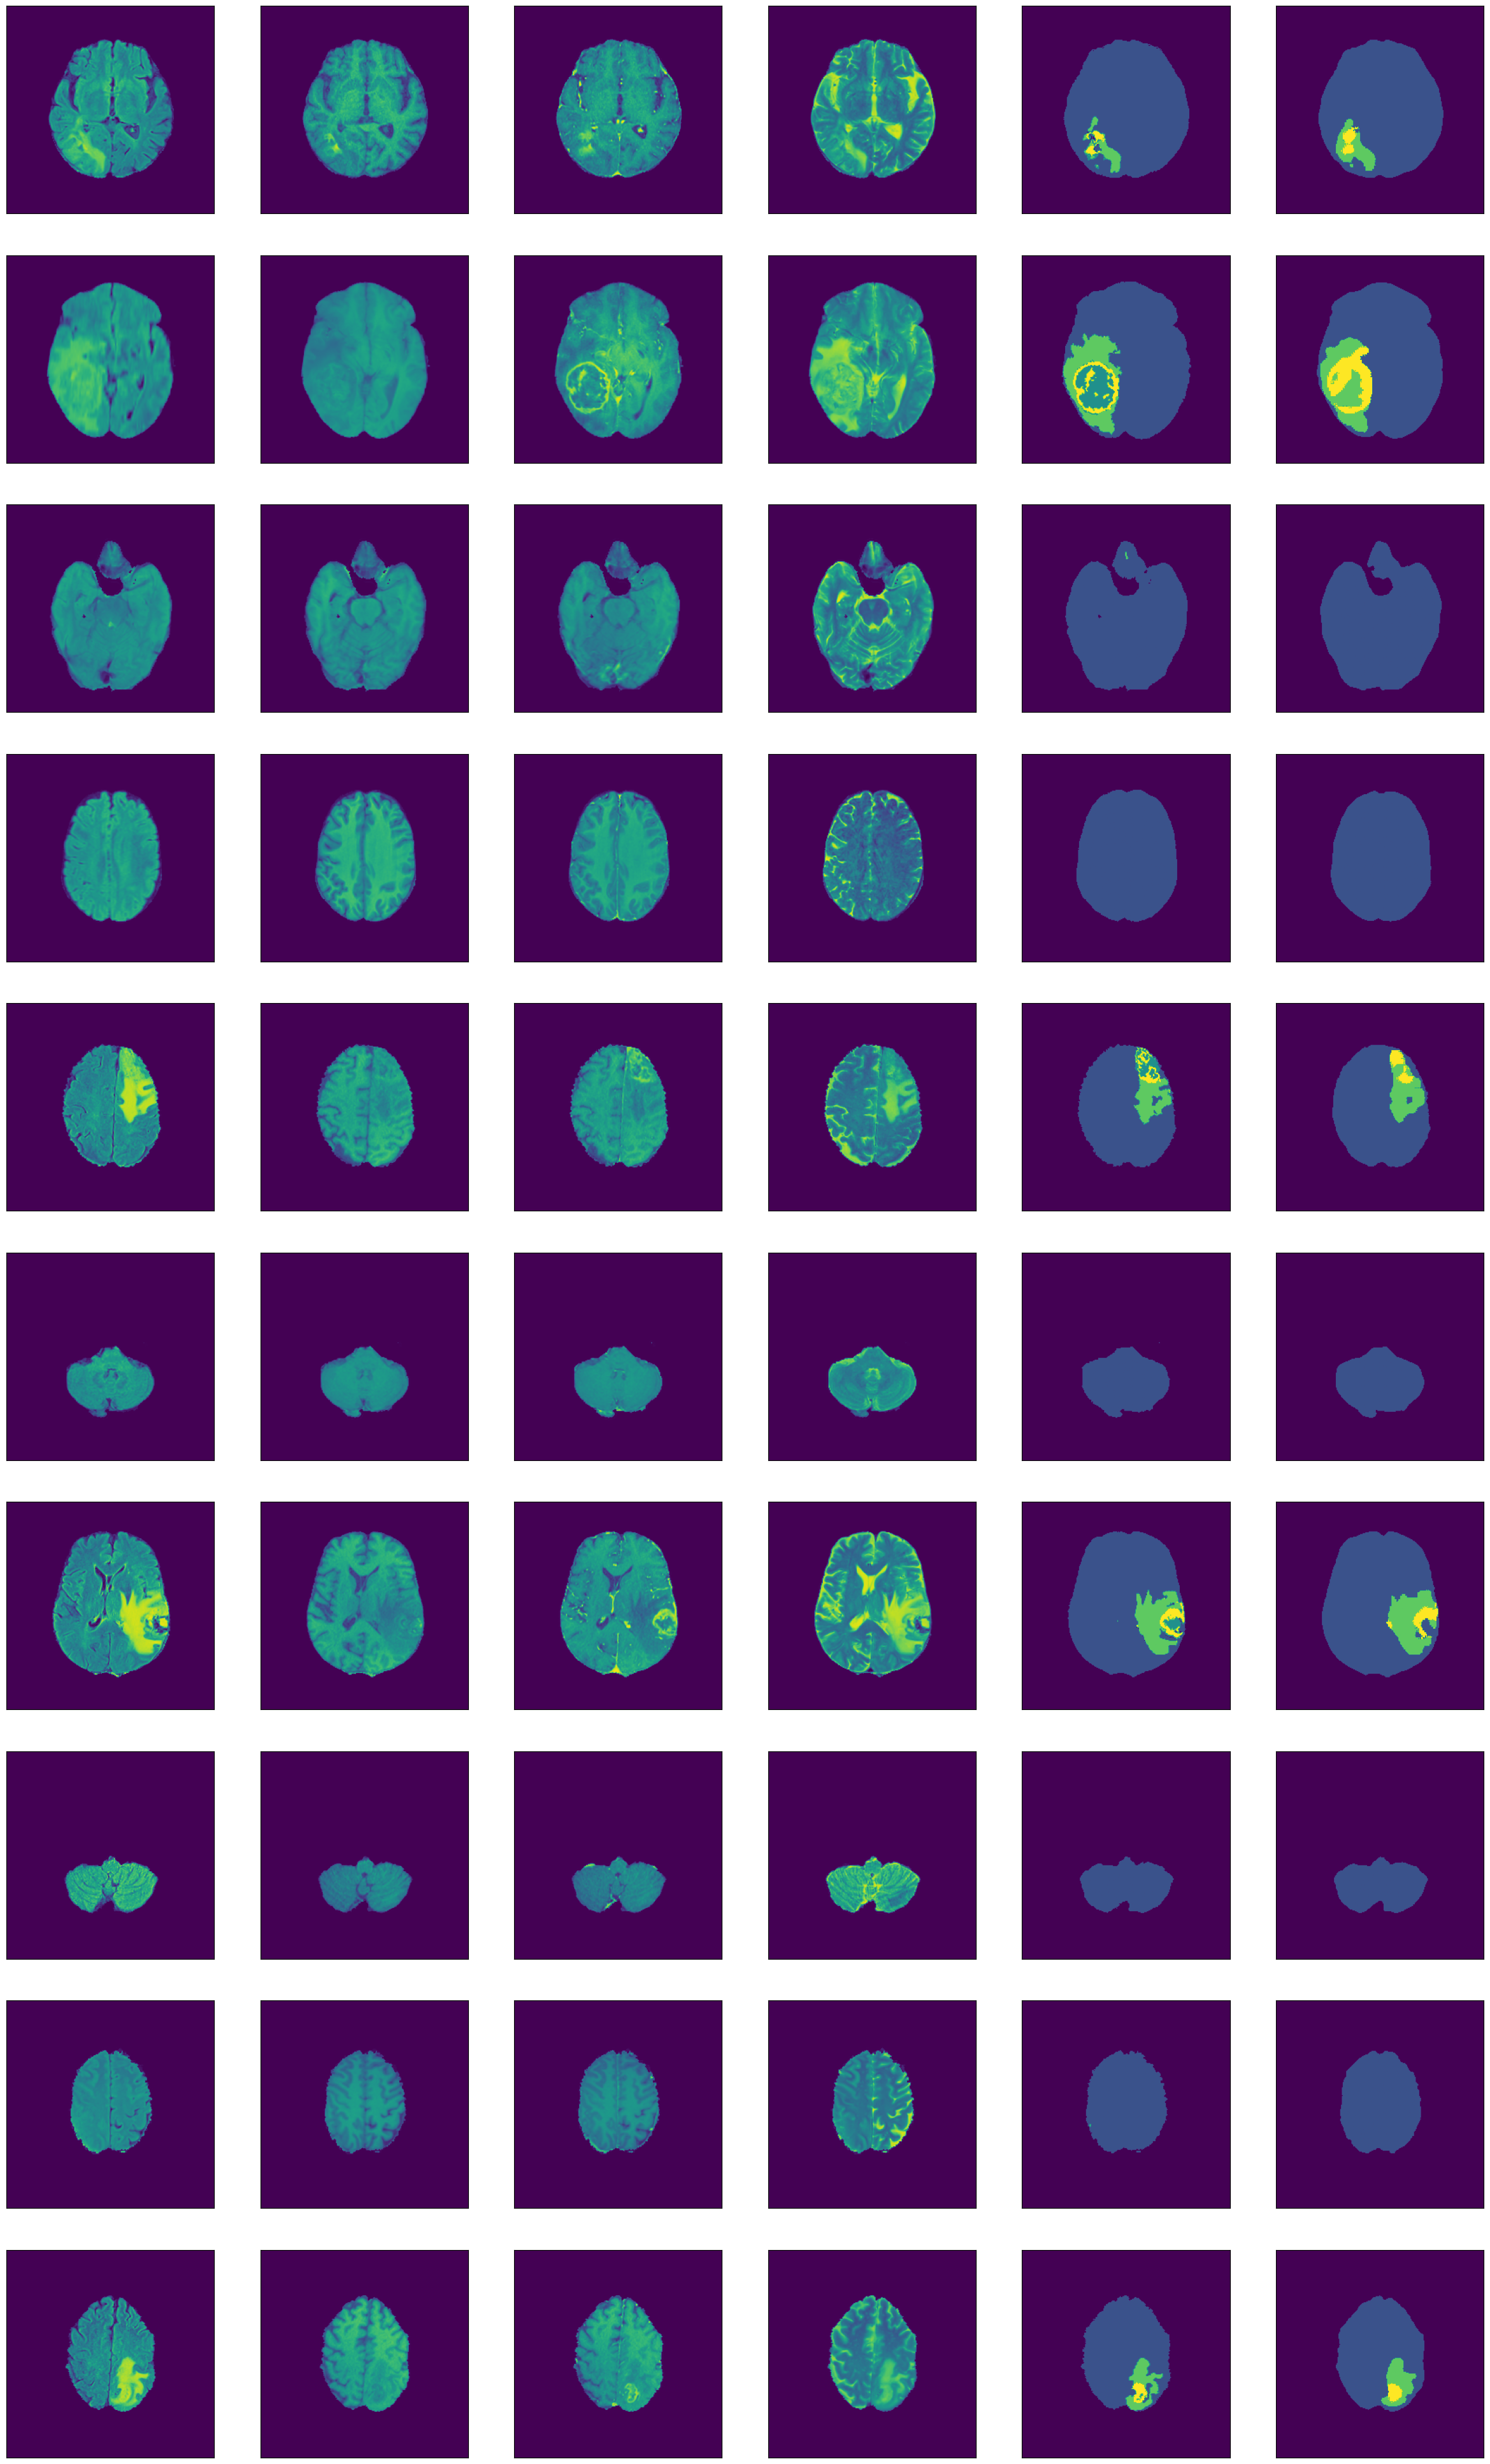

Avancement : 10.00%, Temps écoulé : 0h 04m 10s, Temps restant estimé: 0h 37m 30s, Loss = 0.005281


KeyboardInterrupt: 

In [25]:
batch_size = 10
n_epochs = 100

train(unet_model, train_dataset, test_dataset, train_size, n_epochs=n_epochs, batch_size=batch_size)

In [ ]:
class_scores, global_scores, binary_scores = measure_performance(unet_model, train_dataset, batch_size = 10, show=False)

In [ ]:
class_scores, global_scores, binary_scores = measure_performance(unet_model, test_dataset, batch_size = 10, show=False)